##### top

# Simulate potential span and range of reliabilities estimated using attenuation correction across days

This ntb looks at synthetic data vs real data to estimate the range of possible reliabilities that we could observe by chance if we use attenuation correction on two separate days. The idea is to check the effect of possible outliers that drove this reliability to be more than one in the original dataset.

Specifically this is looking at longitudinal FMP data and 6 days comparison.

NOTE
--
The data for this FMP are not part of the repository. They are stored separately and will be shared publicly separately together with the FMP article.

* [Load and clean data](#Load-and-clean-data)

In [1]:
import os, sys
import time
import pickle 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define path and name
csv_clean_data_path_FMP = "/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/face_memory_experiment_data/experiment_clean_data"

path_results = "../../Data/results"

# Importing module for functions
functions_modul =  "../functions"
sys.path.insert(0, functions_modul)

# import all processing and plotting functions
from reliability_functions import bin_samples_rand4, calculate_reliability_between_two_groups, analytical_C_unbiased, \
get_true_correlation, check_df_get_numbers, extract_data
from simulation_functions import get_subject_means



## Load and clean data
[top](#top)

In [2]:
## longitudinal
# remove participants with too many missed trials
former_bad_guys = set(pd.read_csv(os.path.join(csv_clean_data_path_FMP,'participants_alert.csv'), usecols=["userID"])["userID"].to_numpy())

# load only subjects who have all the days
all_subjects = set(pd.read_csv(os.path.join(csv_clean_data_path_FMP, "experiment_day1_all.csv"), usecols=["userID"]).userID)

for i in range(1,7):
    day="day"+str(i)
    if os.path.exists(os.path.join(csv_clean_data_path_FMP, f"experiment_{day}_all.csv")):
        all_subjects = list(set(all_subjects)&set(pd.read_csv(os.path.join(csv_clean_data_path_FMP, f"experiment_{day}_all.csv"),
                 usecols=["userID"]).userID))
        print(i)

all_subjects = list(set(all_subjects)-former_bad_guys)
print("Num of participants: ", len(all_subjects))

all_days_df = []

for i in range(1,7):
    tmp = None

    day="day"+str(i)
    # check i we have any files
    if os.path.exists(os.path.join(csv_clean_data_path_FMP, f"experiment_{day}_all.csv")):
        tmp = pd.read_csv(os.path.join(csv_clean_data_path_FMP, f"experiment_{day}_all.csv"),
                     usecols=['block', 'stim1', 'stim2',
           'original_target', 'target', 'RT', 'userID', 'observation',
           'stim_gender', 'Form', 'task',
           'num_done', 'stimuli', 'race', 'database', 'age', 'symbolic_age',
           'gender', 'simplified_race', 'order', 'correct_check', 'difficulty',
           'levels', 'correct_flt', 'target_loc_simple', 'target_loc'],
                     dtype={
                            'block': int,
                            'stim1': str,
                            'stim2': str,
                            'original_target': str,
                            'target': str,
                            'RT': float,
                            'userID': str,
                            'observation': str,
                            'stim_gender': str,
                            'Form': str,
                            'task': str,
                            'num_done': int,
                            'stimuli': str,
                            'race': str,
                            'database': str,
                            'age': float,
                            'symbolic_age': str,
                            'gender': str,
                            'simplified_race': str,
                            'order': int,
    #                         'correct_check': object,
                            'difficulty': int,
                            'levels': int,
                            'correct_flt': float,
                            'target_loc_simple': str,
                            'target_loc': str,
                     }
                     )

        tmp = tmp[tmp["userID"].isin(all_subjects)].copy()

        all_days_df.append(tmp)


df_plot_longitudinal = pd.concat(all_days_df)

df_plot_longitudinal.reset_index(inplace=True, drop=True)

# rename col
df_plot_longitudinal.task = df_plot_longitudinal.task.str.replace('perc','perception')
df_plot_longitudinal.rename(columns={"num_done":"visit"}, inplace=True)

# choose only relevant columns
selected_cols = [
    'userID', 'Form', 'task', 'visit',
    'difficulty', 'levels', 'correct_flt', 'target_loc_simple', 'target_loc'
        ]

df_plot_longitudinal = df_plot_longitudinal.loc[:, selected_cols].copy()

1
2
3
4
5
6
Num of participants:  206


In [3]:
outliers_longitudinal = []
std_thr = 2

for d1, d2 in [([3], [5]), ([3,5], [2,4]), ([1,3,5], [2,4,6])]:
    
    # compute differences
    score_diff_FMP = (df_plot_longitudinal[df_plot_longitudinal["visit"].isin(d1)].groupby(['userID']).mean() - df_plot_longitudinal[df_plot_longitudinal["visit"].isin(d2)].groupby(['userID']).mean()).reset_index()

    mean = score_diff_FMP['correct_flt'].mean()
    std = score_diff_FMP['correct_flt'].std()

    # get subjects who are outliers
    outliers_tmp = score_diff_FMP.loc[(score_diff_FMP["correct_flt"] > mean+std_thr*std)|(score_diff_FMP["correct_flt"] < mean-std_thr*std), "userID"].values
#     outliers_longitudinal.append(outliers_tmp)
    outliers_longitudinal += list(outliers_tmp)

    # num of subjects
    print(len(outliers_tmp))
    
# print(f'total: {len(set([item for sublist in outliers_longitudinal for item in sublist]))}')
# print(len(outliers_longitudinal))
print(f'unique total: {len(set(outliers_longitudinal))}')


10
9
6
unique total: 23


In [4]:
# get subjects who are not outliers
not_outliers_FMP_long_all_days = set(df_plot_longitudinal.userID)-set(outliers_longitudinal)
# num of subjects
N_FMP_long_nooutliers_all_days = len(not_outliers_FMP_long_all_days)
assert N_FMP_long_nooutliers_all_days == 206-23
print(f'Out of {df_plot_longitudinal["userID"].unique().size} we take {N_FMP_long_nooutliers_all_days}, we drop {len(set(outliers_longitudinal))}')


## Days 1 and 3 and 5
# select only relevant part of the df
df_short = df_plot_longitudinal.loc[(df_plot_longitudinal['visit'].isin([1,3,5]))&(df_plot_longitudinal['target_loc_simple']=='target_0'), ['userID', 'correct_flt']]
# select the minimum number of trials that everyone has
print(df_short['userID'].value_counts().min())
df_short = df_short.groupby('userID').sample(df_short['userID'].value_counts().min(), random_state=0)
# take only non-outliers
df_short = df_short.loc[df_short["userID"].isin(not_outliers_FMP_long_all_days)].reset_index(drop=True)

# max number of trials
total_n_trials_day135_concat_nooutliers = check_df_get_numbers(df_short, N_FMP_long_nooutliers_all_days)

# extract the data
all_trials_reshaped_target0_day135_concat_nooutliers = extract_data(df_short, total_n_trials_day135_concat_nooutliers, measure="correct_flt")


## Days 2 and 4 and 6
# select only relevant part of the df
df_short = df_plot_longitudinal.loc[(df_plot_longitudinal['visit'].isin([2,4,6]))&(df_plot_longitudinal['target_loc_simple']=='target_0'), ['userID', 'correct_flt']]
# select the minimum number of trials that everyone has
print(df_short['userID'].value_counts().min())
df_short = df_short.groupby('userID').sample(df_short['userID'].value_counts().min(), random_state=0)
# take only non-outliers
df_short = df_short.loc[df_short["userID"].isin(not_outliers_FMP_long_all_days)].reset_index(drop=True)

# max number of trials
total_n_trials_day246_concat_nooutliers = check_df_get_numbers(df_short, N_FMP_long_nooutliers_all_days)

# extract the data
all_trials_reshaped_target0_day246_concat_nooutliers = extract_data(df_short, total_n_trials_day246_concat_nooutliers, measure="correct_flt")


## All days
# select only relevant part of the df
df_short = df_plot_longitudinal.loc[(df_plot_longitudinal['target_loc_simple']=='target_0'), ['userID', 'correct_flt']]
# select the minimum number of trials that everyone has
print(df_short['userID'].value_counts().min())
df_short = df_short.groupby('userID').sample(df_short['userID'].value_counts().min(), random_state=0)
# take only non-outliers
df_short = df_short.loc[df_short["userID"].isin(not_outliers_FMP_long_all_days)].reset_index(drop=True)

# max number of trials
total_n_trials_alldays_concat_nooutliers = check_df_get_numbers(df_short, N_FMP_long_nooutliers_all_days)

# extract the data
all_trials_reshaped_target0_alldays_concat_nooutliers = extract_data(df_short, total_n_trials_alldays_concat_nooutliers, measure="correct_flt")


Out of 206 we take 183, we drop 23
389
Total number of trials is 389.
389
Total number of trials is 389.
786
Total number of trials is 786.


### Get Cs
[top](#top)

In [5]:
for arr, day in zip(
    [all_trials_reshaped_target0_day135_concat_nooutliers, all_trials_reshaped_target0_day246_concat_nooutliers, all_trials_reshaped_target0_alldays_concat_nooutliers],
    ['days 1&3&5', 'days 2&4&6', 'concatenated all days']
):
    mean = np.nanmean(arr)
    var = np.nanmean(arr, axis=1).var()
    C = analytical_C_unbiased(mean, var, arr.shape[1])
    print(f"""{day}
    mean={mean:.2f}, var={var:.5f}, N={arr.shape[0]}, C={C:.2f}, n trials={arr.shape[1]}
    """)

days 1&3&5
    mean=0.76, var=0.00649, N=183, C=28.91, n trials=389
    
days 2&4&6
    mean=0.75, var=0.00758, N=183, C=25.03, n trials=389
    
concatenated all days
    mean=0.76, var=0.00666, N=183, C=27.44, n trials=786
    


## Use simulations to get a range/CI for the curves
[top](#top)

We want to mimic the experiment closely, so we will use N=183 and for the largest n trials we can get, 128. 


In [6]:
# define the data
dic_tasks_results = {}

# define how many times to split the data
n_splits = 1000
n_repeats = 10**3
# define how many trials we want to check, this is how many trials there are in the concat version
n_trials = 2*384

# for how many subjects to compute it, this is a mean of the ones in panel C
N_sim = 183

# set step separately
step = n_trials//4

# define the data
task = "FMP_longitudinal_3d_synthetic"
print(task)
dic_tasks_results[task] = {}

# extract statistics of the data
mean = np.nanmean(all_trials_reshaped_target0_alldays_concat_nooutliers)
var = np.nanmean(all_trials_reshaped_target0_alldays_concat_nooutliers, axis=1).var()
# std = np.nanmean(all_trials_reshaped_target0_alldays_concat_nooutliers, axis=1).std()
C = analytical_C_unbiased(mean, var, n_trials)

# create dic
dic_tasks_results[task]["original_C"] = C
dic_tasks_results[task]["defined_C"] = C/2 + C//2 # alpha+beta in the beta distribution below
    

# start the timer
start = time.time()


print(n_trials)
# create data
rng_means = np.random.default_rng(0)
means = get_subject_means(C/2, C//2, N_sim, 'beta', rng_means)

rng_data = np.random.default_rng(0)
concat_array_C = bin_samples_rand4(rng_data, N_sim, n_trials, means, ravel=False)

## Run the simulations

# predefine arrays
array_corr_fxn_orig = np.zeros((n_splits, n_trials//4//step, n_repeats))
array_corr_fxn_rep = np.zeros((n_splits, n_trials//4//step, n_repeats))
array_corr_fxn_orig_vs_rep = np.zeros((n_splits, n_trials//2//step, n_repeats))
r_xy_array = np.zeros((n_splits, n_trials//4//step))

# simulate the different splits
for s in range(n_splits):
    # define random splitter
    rng_split = np.random.default_rng(s)

    # split the data into two days
    random_idx = rng_split.choice(range(concat_array_C.shape[1]), n_trials//2, replace=False)
    random_idx2 = np.asarray(list(set(range(concat_array_C.shape[1])) - set(random_idx)))

    day1_array = concat_array_C[:, random_idx]
    day2_array = concat_array_C[:, random_idx2]

    ### Run analysis
    ## Short arrays
    array_corr_fxn_orig[s], n_trials_list_orig = calculate_reliability_between_two_groups(day1_array, day1_array, n_trials//2, n_repeats=n_repeats, step=step)
    array_corr_fxn_rep[s], n_trials_list_rep = calculate_reliability_between_two_groups(day2_array, day2_array, n_trials//2, n_repeats=n_repeats, step=step)

    ## Long arrays
    array_corr_fxn_orig_vs_rep[s], n_trials_list_orig_vs_rep = calculate_reliability_between_two_groups(day1_array, day2_array, n_trials, n_repeats=n_repeats, step=step)


    # get the true correlation
    r_xy_array[s] = get_true_correlation(
        np.nanmean(array_corr_fxn_orig_vs_rep[s, :len(n_trials_list_orig)], axis=1),
        np.nanmean(array_corr_fxn_orig[s], axis=1), 
        np.nanmean(array_corr_fxn_rep[s], axis=1)
    )

# save
dic_tasks_results[task][n_trials] = {
    'data': concat_array_C,
    'array_corr_fxn_orig': array_corr_fxn_orig,
    'n_trials_list_orig': n_trials_list_orig,
    'array_corr_fxn_rep': array_corr_fxn_rep,
    'n_trials_list_rep': n_trials_list_rep,
    'array_corr_fxn_orig_vs_rep': array_corr_fxn_orig_vs_rep,
    'n_trials_list_orig_vs_rep': n_trials_list_orig_vs_rep,
    'r_xy_array': r_xy_array,
    'n_splits': n_splits,
}

print(f"Process took: {time.time() - start:.2f} s which is {(time.time() - start) / 60:.2f} min.\n")


FMP_longitudinal_3d_synthetic
768
Process took: 0.42 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.89 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.82 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.86 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.83 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.80 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.84 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Proces

Process took: 0.41 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.80 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.82 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.


Process took: 0.41 s which is 0.01 min.
Process took: 0.77 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.80 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.


Process took: 0.78 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.77 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.80 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.80 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.


Process took: 0.44 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.77 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.77 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.77 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.81 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.


Process took: 0.41 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.81 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.81 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.


Process took: 0.79 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.80 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.77 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.


Process took: 0.42 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.83 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.81 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.82 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.


Process took: 0.42 s which is 0.01 min.
Process took: 0.80 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.80 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.77 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.


Process took: 0.77 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.80 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.77 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.81 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.80 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.81 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.


Process took: 0.45 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.88 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.90 s which is 0.02 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.83 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.84 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.85 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.85 s which is 0.01 min.
Process took: 0.64 s which is 0.01 min.
Process took: 0.71 s which is 0.01 min.
Process took: 1.07 s which is 0.02 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.90 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.


Process took: 0.46 s which is 0.01 min.
Process took: 0.86 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.86 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.87 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.88 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.89 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.89 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.90 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.90 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.


Process took: 0.87 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.82 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.88 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.76 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.76 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.80 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.76 s which is 0.01 min.


Process took: 0.45 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.76 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.77 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.81 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.81 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.77 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.


Process took: 0.42 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.88 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.86 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.76 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.87 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.81 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.87 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.80 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.


In [7]:
# dic_tasks_results[task][n_trials]

In [8]:
# dic_tasks_results[task][80]['r_xy_array']

In [9]:
# make a copy
dic_tasks_results_backup = dic_tasks_results

In [10]:
# define the data
# dic_tasks_results = {}

# define how many times to split the data
n_splits = 1000
n_repeats = 10**3
# define how many trials we want to check, this is how many trials there are in the concat version
n_trials = 2*384

# # for how many subjects to compute it, this is a mean of the ones in panel C
# N_sim = 183

# set step separately
step = n_trials//4

# define the data
task = "FMP_longitudinal_3d_real"
print(task)
dic_tasks_results[task] = {}

# extract statistics of the data
mean = np.nanmean(all_trials_reshaped_target0_alldays_concat_nooutliers)
var = np.nanmean(all_trials_reshaped_target0_alldays_concat_nooutliers, axis=1).var()
# std = np.nanmean(all_trials_reshaped_target0_alldays_concat_nooutliers, axis=1).std()
C = analytical_C_unbiased(mean, var, n_trials)

# create dic
dic_tasks_results[task]["original_C"] = C
dic_tasks_results[task]["defined_C"] = C/2 + C//2 # alpha+beta in the beta distribution below
    

# start the timer
start = time.time()


print(n_trials)
# # create data
# rng_means = np.random.default_rng(0)
# means = get_subject_means(C/2, C//2, N_sim, 'beta', rng_means)

# rng_data = np.random.default_rng(0)
# concat_array_C = bin_samples_rand4(rng_data, N_sim, n_trials, means, ravel=False)
concat_array_C = all_trials_reshaped_target0_alldays_concat_nooutliers.copy()

## Run the simulations

# predefine arrays
array_corr_fxn_orig = np.zeros((n_splits, n_trials//4//step, n_repeats))
array_corr_fxn_rep = np.zeros((n_splits, n_trials//4//step, n_repeats))
array_corr_fxn_orig_vs_rep = np.zeros((n_splits, n_trials//2//step, n_repeats))
r_xy_array = np.zeros((n_splits, n_trials//4//step))

# simulate the different splits
for s in range(n_splits):
    # define random splitter
    rng_split = np.random.default_rng(s)

    # split the data into two days
    random_idx = rng_split.choice(range(concat_array_C.shape[1]), n_trials//2, replace=False)
    random_idx2 = np.asarray(list(set(range(concat_array_C.shape[1])) - set(random_idx)))

    day1_array = concat_array_C[:, random_idx]
    day2_array = concat_array_C[:, random_idx2]

    ### Run analysis
    ## Short arrays
    array_corr_fxn_orig[s], n_trials_list_orig = calculate_reliability_between_two_groups(day1_array, day1_array, n_trials//2, n_repeats=n_repeats, step=step)
    array_corr_fxn_rep[s], n_trials_list_rep = calculate_reliability_between_two_groups(day2_array, day2_array, n_trials//2, n_repeats=n_repeats, step=step)

    ## Long arrays
    array_corr_fxn_orig_vs_rep[s], n_trials_list_orig_vs_rep = calculate_reliability_between_two_groups(day1_array, day2_array, n_trials, n_repeats=n_repeats, step=step)


    # get the true correlation
    r_xy_array[s] = get_true_correlation(
        np.nanmean(array_corr_fxn_orig_vs_rep[s, :len(n_trials_list_orig)], axis=1),
        np.nanmean(array_corr_fxn_orig[s], axis=1), 
        np.nanmean(array_corr_fxn_rep[s], axis=1)
    )

# save
dic_tasks_results[task][n_trials] = {
    'data': concat_array_C,
    'array_corr_fxn_orig': array_corr_fxn_orig,
    'n_trials_list_orig': n_trials_list_orig,
    'array_corr_fxn_rep': array_corr_fxn_rep,
    'n_trials_list_rep': n_trials_list_rep,
    'array_corr_fxn_orig_vs_rep': array_corr_fxn_orig_vs_rep,
    'n_trials_list_orig_vs_rep': n_trials_list_orig_vs_rep,
    'r_xy_array': r_xy_array,
    'n_splits': n_splits,
}

print(f"Process took: {time.time() - start:.2f} s which is {(time.time() - start) / 60:.2f} min.\n")


FMP_longitudinal_3d_real
768
Process took: 0.68 s which is 0.01 min.
Process took: 0.68 s which is 0.01 min.
Process took: 1.45 s which is 0.02 min.
Process took: 0.65 s which is 0.01 min.
Process took: 0.60 s which is 0.01 min.
Process took: 1.43 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.59 s which is 0.01 min.
Process took: 1.38 s which is 0.02 min.
Process took: 0.59 s which is 0.01 min.
Process took: 0.60 s which is 0.01 min.
Process took: 1.30 s which is 0.02 min.
Process took: 0.61 s which is 0.01 min.
Process took: 0.58 s which is 0.01 min.
Process took: 1.33 s which is 0.02 min.
Process took: 0.60 s which is 0.01 min.
Process took: 0.68 s which is 0.01 min.
Process took: 1.46 s which is 0.02 min.
Process took: 0.62 s which is 0.01 min.
Process took: 0.60 s which is 0.01 min.
Process took: 1.30 s which is 0.02 min.
Process took: 0.60 s which is 0.01 min.
Process took: 0.61 s which is 0.01 min.
Process took: 1.33 s which is 0.02 min.
Process too

Process took: 0.61 s which is 0.01 min.
Process took: 1.36 s which is 0.02 min.
Process took: 0.60 s which is 0.01 min.
Process took: 0.63 s which is 0.01 min.
Process took: 1.54 s which is 0.03 min.
Process took: 0.60 s which is 0.01 min.
Process took: 0.66 s which is 0.01 min.
Process took: 1.34 s which is 0.02 min.
Process took: 0.60 s which is 0.01 min.
Process took: 0.61 s which is 0.01 min.
Process took: 1.31 s which is 0.02 min.
Process took: 0.65 s which is 0.01 min.
Process took: 0.64 s which is 0.01 min.
Process took: 1.50 s which is 0.02 min.
Process took: 0.68 s which is 0.01 min.
Process took: 0.64 s which is 0.01 min.
Process took: 1.37 s which is 0.02 min.
Process took: 0.64 s which is 0.01 min.
Process took: 0.63 s which is 0.01 min.
Process took: 1.39 s which is 0.02 min.
Process took: 0.58 s which is 0.01 min.
Process took: 0.61 s which is 0.01 min.
Process took: 1.49 s which is 0.02 min.
Process took: 0.69 s which is 0.01 min.
Process took: 0.63 s which is 0.01 min.


Process took: 1.35 s which is 0.02 min.
Process took: 0.58 s which is 0.01 min.
Process took: 0.65 s which is 0.01 min.
Process took: 1.31 s which is 0.02 min.
Process took: 0.61 s which is 0.01 min.
Process took: 0.61 s which is 0.01 min.
Process took: 1.22 s which is 0.02 min.
Process took: 0.64 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.46 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.58 s which is 0.01 min.
Process took: 1.31 s which is 0.02 min.
Process took: 0.59 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.33 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.59 s which is 0.01 min.
Process took: 1.26 s which is 0.02 min.
Process took: 0.59 s which is 0.01 min.
Process took: 0.61 s which is 0.01 min.
Process took: 1.27 s which is 0.02 min.
Process took: 0.61 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.31 s which is 0.02 min.


Process took: 0.64 s which is 0.01 min.
Process took: 0.59 s which is 0.01 min.
Process took: 1.33 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.59 s which is 0.01 min.
Process took: 1.28 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.25 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.61 s which is 0.01 min.
Process took: 1.26 s which is 0.02 min.
Process took: 0.58 s which is 0.01 min.
Process took: 0.61 s which is 0.01 min.
Process took: 1.23 s which is 0.02 min.
Process took: 0.61 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.29 s which is 0.02 min.
Process took: 0.61 s which is 0.01 min.
Process took: 0.58 s which is 0.01 min.
Process took: 1.29 s which is 0.02 min.
Process took: 0.60 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.34 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.


Process took: 0.58 s which is 0.01 min.
Process took: 1.28 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.17 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.20 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.37 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.19 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.21 s which is 0.02 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.16 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.63 s which is 0.01 min.
Process took: 1.15 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.


Process took: 1.16 s which is 0.02 min.
Process took: 0.53 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.17 s which is 0.02 min.
Process took: 0.58 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.17 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.17 s which is 0.02 min.
Process took: 0.53 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.17 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.18 s which is 0.02 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.19 s which is 0.02 min.
Process took: 0.53 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.20 s which is 0.02 min.
Process took: 0.53 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.21 s which is 0.02 min.


Process took: 0.61 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.47 s which is 0.02 min.
Process took: 0.59 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.35 s which is 0.02 min.
Process took: 0.69 s which is 0.01 min.
Process took: 0.69 s which is 0.01 min.
Process took: 1.53 s which is 0.03 min.
Process took: 0.65 s which is 0.01 min.
Process took: 0.64 s which is 0.01 min.
Process took: 1.17 s which is 0.02 min.
Process took: 0.53 s which is 0.01 min.
Process took: 0.59 s which is 0.01 min.
Process took: 1.17 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.33 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.18 s which is 0.02 min.
Process took: 0.62 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.20 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.


Process took: 0.61 s which is 0.01 min.
Process took: 1.24 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.58 s which is 0.01 min.
Process took: 1.22 s which is 0.02 min.
Process took: 0.59 s which is 0.01 min.
Process took: 0.59 s which is 0.01 min.
Process took: 1.23 s which is 0.02 min.
Process took: 0.65 s which is 0.01 min.
Process took: 0.62 s which is 0.01 min.
Process took: 1.26 s which is 0.02 min.
Process took: 0.58 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.32 s which is 0.02 min.
Process took: 0.58 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.22 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.60 s which is 0.01 min.
Process took: 1.29 s which is 0.02 min.
Process took: 0.73 s which is 0.01 min.
Process took: 0.64 s which is 0.01 min.
Process took: 1.50 s which is 0.02 min.
Process took: 0.73 s which is 0.01 min.
Process took: 0.68 s which is 0.01 min.


Process took: 1.22 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.24 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.29 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.21 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.19 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.58 s which is 0.01 min.
Process took: 1.29 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.24 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.28 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.63 s which is 0.01 min.
Process took: 1.30 s which is 0.02 min.


Process took: 0.58 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.21 s which is 0.02 min.
Process took: 0.58 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.30 s which is 0.02 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.28 s which is 0.02 min.
Process took: 0.58 s which is 0.01 min.
Process took: 0.58 s which is 0.01 min.
Process took: 1.24 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.24 s which is 0.02 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.20 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.25 s which is 0.02 min.
Process took: 0.59 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.18 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.


Process took: 0.55 s which is 0.01 min.
Process took: 1.21 s which is 0.02 min.
Process took: 0.58 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.24 s which is 0.02 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.24 s which is 0.02 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.58 s which is 0.01 min.
Process took: 1.32 s which is 0.02 min.
Process took: 0.59 s which is 0.01 min.
Process took: 0.61 s which is 0.01 min.
Process took: 1.27 s which is 0.02 min.
Process took: 0.59 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.30 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.26 s which is 0.02 min.
Process took: 0.59 s which is 0.01 min.
Process took: 0.61 s which is 0.01 min.
Process took: 1.26 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.


Process took: 1.20 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.22 s which is 0.02 min.
Process took: 0.58 s which is 0.01 min.
Process took: 0.59 s which is 0.01 min.
Process took: 1.25 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.26 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.18 s which is 0.02 min.
Process took: 0.59 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.19 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.21 s which is 0.02 min.
Process took: 0.61 s which is 0.01 min.
Process took: 0.59 s which is 0.01 min.
Process took: 1.27 s which is 0.02 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.19 s which is 0.02 min.


Process took: 0.55 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.26 s which is 0.02 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.58 s which is 0.01 min.
Process took: 1.24 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.20 s which is 0.02 min.
Process took: 0.59 s which is 0.01 min.
Process took: 0.62 s which is 0.01 min.
Process took: 1.32 s which is 0.02 min.
Process took: 0.59 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.19 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.26 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.19 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.25 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.


Process took: 0.59 s which is 0.01 min.
Process took: 1.48 s which is 0.02 min.
Process took: 0.59 s which is 0.01 min.
Process took: 0.62 s which is 0.01 min.
Process took: 1.38 s which is 0.02 min.
Process took: 0.62 s which is 0.01 min.
Process took: 0.60 s which is 0.01 min.
Process took: 1.35 s which is 0.02 min.
Process took: 0.58 s which is 0.01 min.
Process took: 0.61 s which is 0.01 min.
Process took: 1.36 s which is 0.02 min.
Process took: 0.59 s which is 0.01 min.
Process took: 0.60 s which is 0.01 min.
Process took: 1.31 s which is 0.02 min.
Process took: 0.63 s which is 0.01 min.
Process took: 0.62 s which is 0.01 min.
Process took: 1.37 s which is 0.02 min.
Process took: 0.60 s which is 0.01 min.
Process took: 0.60 s which is 0.01 min.
Process took: 1.37 s which is 0.02 min.
Process took: 0.58 s which is 0.01 min.
Process took: 0.62 s which is 0.01 min.
Process took: 1.38 s which is 0.02 min.
Process took: 0.58 s which is 0.01 min.
Process took: 0.60 s which is 0.01 min.


Process took: 1.35 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.62 s which is 0.01 min.
Process took: 1.36 s which is 0.02 min.
Process took: 0.58 s which is 0.01 min.
Process took: 0.59 s which is 0.01 min.
Process took: 1.31 s which is 0.02 min.
Process took: 0.59 s which is 0.01 min.
Process took: 0.62 s which is 0.01 min.
Process took: 1.30 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.58 s which is 0.01 min.
Process took: 1.26 s which is 0.02 min.
Process took: 0.59 s which is 0.01 min.
Process took: 0.62 s which is 0.01 min.
Process took: 1.31 s which is 0.02 min.
Process took: 0.59 s which is 0.01 min.
Process took: 0.59 s which is 0.01 min.
Process took: 1.33 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.60 s which is 0.01 min.
Process took: 1.26 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.59 s which is 0.01 min.
Process took: 1.41 s which is 0.02 min.


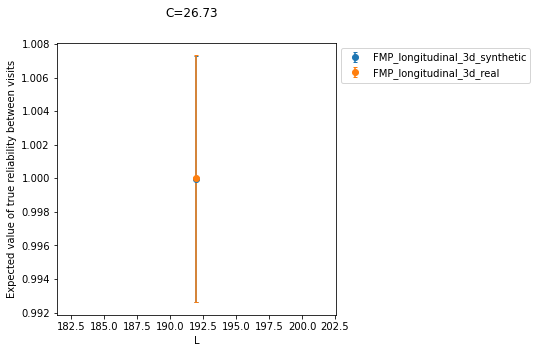

In [18]:
fig, ax = plt.subplots(1,1, figsize=(5,5), sharey=True)

for i,task in enumerate(dic_tasks_results.keys()):
    r_xy_array = dic_tasks_results[task][n_trials]['r_xy_array']

#     ax.scatter(dic_tasks_results[task][n_trials]['n_trials_list_orig'], r_xy_array.mean(axis=0))
    ax.errorbar(dic_tasks_results[task][n_trials]['n_trials_list_orig'], r_xy_array.mean(axis=0), 
                yerr=np.nanstd(r_xy_array, axis=0), fmt='o', capsize=2, label=task)

    ax.set_ylabel('Expected value of true reliability between visits')
    ax.set_xlabel('L')

plt.suptitle(f"C={dic_tasks_results[task]['defined_C']:.2f}")
plt.legend(bbox_to_anchor=(1,1))
plt.show()
# axs[1].scatter(n_trials_list_GFMT_orig, r_xy_array.mean(axis=0))
# axs[1].errorbar(n_trials_list_GFMT_orig, r_xy_array.mean(axis=0), yerr=np.nanstd(r_xy_array, axis=0), fmt='o', capsize=2)
    
# axs[1].set_ylabel('Expected value of true reliability between visits')
# axs[1].set_xlabel('L')


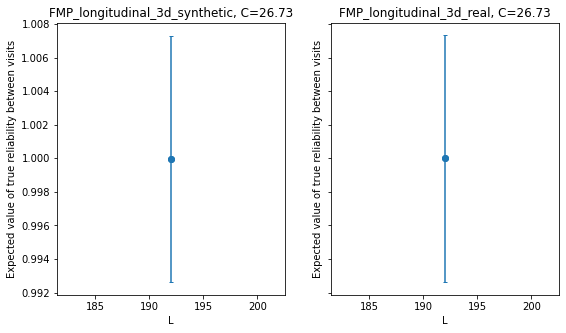

In [12]:
fig, axs = plt.subplots(1,2, figsize=(9,5), sharey=True)

for task,ax in zip(dic_tasks_results.keys(), axs.flatten()):
    r_xy_array = dic_tasks_results[task][n_trials]['r_xy_array']

    ax.scatter(dic_tasks_results[task][n_trials]['n_trials_list_orig'], r_xy_array.mean(axis=0))
    ax.errorbar(dic_tasks_results[task][n_trials]['n_trials_list_orig'], r_xy_array.mean(axis=0), 
                yerr=np.nanstd(r_xy_array, axis=0), fmt='o', capsize=2)

    ax.set_ylabel('Expected value of true reliability between visits')
    ax.set_xlabel('L')

    ax.set_title(f"{task}, C={dic_tasks_results[task]['defined_C']:.2f}")
plt.show()
# axs[1].scatter(n_trials_list_GFMT_orig, r_xy_array.mean(axis=0))
# axs[1].errorbar(n_trials_list_GFMT_orig, r_xy_array.mean(axis=0), yerr=np.nanstd(r_xy_array, axis=0), fmt='o', capsize=2)
    
# axs[1].set_ylabel('Expected value of true reliability between visits')
# axs[1].set_xlabel('L')


#### Combine the dictionaries
[top](#top)

In [13]:
# make a copy
dic_tasks_results_backup = dic_tasks_results

In [19]:
# load the saved dict with reliability errors
with open(os.path.join(path_results, 'simulated_reliability_range_largestL_nsim_1000.pkl'), 'rb') as f:
    dic_reliability_error = pickle.load(f)
    
print(dic_reliability_error.keys())
dic_reliability_error

dict_keys(['FMP_longitudinal_1d_synthetic', 'FMP_longitudinal_1d_real', 'FMP_longitudinal_2d_synthetic', 'FMP_longitudinal_2d_real'])


{'FMP_longitudinal_1d_synthetic': {'original_C': 24.23783939774275,
  'defined_C': 24.118919698871373,
  256: {'data': array([[0, 1, 1, ..., 0, 0, 1],
          [0, 1, 0, ..., 0, 0, 0],
          [0, 0, 1, ..., 0, 1, 0],
          ...,
          [1, 1, 1, ..., 1, 0, 1],
          [0, 0, 1, ..., 1, 0, 0],
          [1, 0, 0, ..., 1, 0, 1]], dtype=uint8),
   'array_corr_fxn_orig': array([[[0.71799111, 0.72446091, 0.75183189, ..., 0.72330662,
            0.73193903, 0.73302571]],
   
          [[0.78102795, 0.71581481, 0.73616726, ..., 0.73774696,
            0.74129592, 0.7455944 ]],
   
          [[0.75107317, 0.7192747 , 0.7177304 , ..., 0.74740491,
            0.73033875, 0.70729495]],
   
          ...,
   
          [[0.77140676, 0.74320533, 0.78862551, ..., 0.74740208,
            0.76149436, 0.72674804]],
   
          [[0.75420734, 0.7620906 , 0.76165159, ..., 0.75278927,
            0.73020611, 0.70350926]],
   
          [[0.72929245, 0.73393746, 0.723851  , ..., 0.7103814 ,
  

In [20]:
# save this dic to it
for key in dic_tasks_results.keys():
    dic_reliability_error[key] = dic_tasks_results[key]

In [21]:
# save
with open(os.path.join(path_results, f'simulated_reliability_range_largestL_nsim_{n_splits}.pkl'), 'wb') as f:
    pickle.dump(dic_reliability_error, f)
        


In [17]:
%load_ext watermark

%watermark -a 'Jan Kadlec' -nmvu -iv

Author: Jan Kadlec

Last updated: Wed Dec 20 2023

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.26.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 23.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

sys       : 3.8.11 (default, Aug  6 2021, 08:56:27) 
[Clang 10.0.0 ]
pandas    : 1.2.4
numpy     : 1.19.1
matplotlib: 3.6.2
seaborn   : 0.11.1



[top](#top)